# Model-based diffuser

In [1]:
import jax
import chex
from jax import lax
from jax import numpy as jnp
from flax import struct
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
%matplotlib widget

Initialize the parameters

In [46]:
# global static parameters
n_state: int = 4
n_action: int = 2
horizon: int = 50
diffuse_step = 10
diffuse_substeps = 10 #20

# schedule langevin episilon
langevin_eps_schedule = jnp.linspace(1.0, 0.5, diffuse_substeps) * 1e-5 

# schedule global noise (perturbation noise)
noise_var_init = 5e-2
# noise_var_init = 2e-5
noise_var_final = 2e-5
# plan in exponential space
scale = 6.0
noise_var_schedule = jnp.exp(jnp.linspace(scale,0.0,diffuse_step))/jnp.exp(scale)
noise_var_schedule = noise_var_schedule * (noise_var_init - noise_var_final) + noise_var_final
# noise_std_schedule = jnp.linspace(noise_std_init, noise_std_final, diffuse_step)

In [47]:
def default_array(array):
    return struct.field(default_factory=lambda: jnp.array(array))

@struct.dataclass
class Params:
    # environment parameters
    dt: float = 0.1
    r_obs: float = 0.2
    init_state: jnp.ndarray = default_array([-1.0, 0.0, 0.0, 0.0])
    goal_state: jnp.ndarray = default_array([1.0, 0.0, 0.0, 0.0])

    # diffuser parameters
    noise_var: float = 0.1**2
    langevin_eps: float = 0.1

In [48]:
def get_A(x: jnp.ndarray, params: Params) -> jnp.ndarray:
    return jnp.array(
        [
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
            [0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0],
        ]
    ) * params.dt + jnp.eye(n_state)


def get_B(x: jnp.ndarray, params: Params) -> jnp.ndarray:
    return (
        jnp.array(
            [
                [0.0, 0.0],
                [0.0, 0.0],
                [1.0, 0.0],
                [0.0, 1.0],
            ]
        )
        * params.dt
    )

dynamic related functions

In [49]:
def get_reward(
    x_traj: jnp.ndarray,
    u_traj: jnp.ndarray,
    params: Params,
) -> jnp.ndarray:
    def get_running_cost(x: jnp.ndarray, u: jnp.ndarray) -> jnp.ndarray:
        Q = jnp.diag(jnp.array([10.0, 10.0, 1.0, 1.0]))
        R = jnp.eye(n_action) * 0.1
        x_err = x - params.goal_state   
        return (x_err @ Q @ x_err + u @ R @ u) / 2.0

    running_cost = jax.vmap(get_running_cost)(x_traj, u_traj).sum()
    return -running_cost.sum()

def get_barrier_sphere(x_traj: jnp.ndarray, params: Params) -> jnp.ndarray:
    def get_barrier_cost(x: jnp.ndarray) -> jnp.ndarray:
        dist2center = jnp.linalg.norm(x[:2])
        return jnp.clip((params.r_obs-dist2center), 0.0, params.r_obs)**2

    barrier_cost = jax.vmap(get_barrier_cost)(x_traj).sum()
    return -barrier_cost

def get_barrier_rect(x_traj: jnp.ndarray, params: Params) -> jnp.ndarray:
    rect1_center = jnp.array([0.0, 0.0])
    rect1_half = jnp.array([0.2, 0.5])
    # calculate the distance to the edge of the rectangle\n
    def get_barrier_cost(x: jnp.ndarray) -> jnp.ndarray:
        x = x[:2]
        x_centered = jnp.clip(jnp.abs(x - rect1_center), jnp.zeros(2), rect1_half)
        dx = rect1_half - x_centered
        return jnp.minimum(dx[0], dx[1])**2*10.0
    barrier_cost = jax.vmap(get_barrier_cost)(x_traj).sum()
    return -barrier_cost

get_barrier = get_barrier_sphere

def get_logpd_scan(x_traj: jnp.ndarray, u_traj: jnp.ndarray, params: Params) -> jnp.ndarray:
    def step(state, input):
        x_hat, cov_hat, logpd = state
        u_prev, x_current = input
        A = get_A(x_hat, params)
        B = get_B(x_hat, params)
        Q = B @ B.T * params.noise_var
        R = jnp.eye(n_state) * params.noise_var
        x_pred = A @ x_hat + B @ u_prev
        cov_pred = A @ cov_hat @ A.T + Q
        K = cov_pred @ jnp.linalg.inv(cov_pred + R)
        x_hat = x_pred + K @ (x_current - x_pred)
        cov_hat = (jnp.eye(n_state) - K) @ cov_pred
        y_cov_pred = cov_pred + R
        logpd += -0.5 * (
            jnp.log(2 * jnp.pi) * n_state
            + jnp.linalg.slogdet(y_cov_pred)[1]
            + (x_current - x_pred).T @ jnp.linalg.inv(y_cov_pred) @ (x_current - x_pred)
        )
        return (x_hat, cov_hat, logpd), None

    x_hat = x_traj[0]
    cov_hat = jnp.eye(n_state) * 0.0
    logpd = 0.0
    initial_state = (x_hat, cov_hat, logpd)

    inputs = (u_traj, x_traj)
    (x_hat, cov_hat, logpd), _ = lax.scan(step, initial_state, inputs)
    return logpd

key function: update the state of the diffuser

In [60]:
def update_traj(
    x_traj: jnp.ndarray,
    u_traj: jnp.ndarray,
    params: Params,
    rng: chex.PRNGKey,
) -> jnp.ndarray:
    reward_grad = jax.grad(get_reward, argnums=[0, 1])
    reward_grad_x, reward_grad_u = reward_grad(x_traj, u_traj, params)

    logpd_grad = jax.grad(get_logpd_scan, argnums=[0, 1])
    logpd_grad_x, logpd_grad_u = logpd_grad(
        x_traj, u_traj, params
    )

    barrier_grad = jax.grad(get_barrier, argnums=0)
    barrier_grad_x = barrier_grad(x_traj, params)

    logp_dyn = get_logpd_scan(x_traj, u_traj, params)
    barrier_value = get_barrier(x_traj, params)
    barrier_scale = 1.0 / params.noise_var
    reward_scale = jnp.clip((logp_dyn+100.0)*0.01, 0.0, 1.0) * jnp.clip((barrier_value+0.02)*50.0, 0.0, 1.0) # / params.noise_var
    grad_x = logpd_grad_x + reward_grad_x * reward_scale + barrier_grad_x * barrier_scale

    grad_u = logpd_grad_u + reward_grad_u * reward_scale
    eps = params.langevin_eps
    rng, rng_x, rng_u = jax.random.split(rng, 3)
    
    x_traj_new = (
        x_traj
        + eps * grad_x
        + jnp.sqrt(2 * eps) * jax.random.normal(rng_x, grad_x.shape)
    )
    x_traj_new = x_traj_new.at[0].set(
        params.init_state
    )  # NOTE: do not add noise to the initial state
    x_traj_new = x_traj_new.at[-1].set(
        params.goal_state
    )  # NOTE: do not add noise to the final state

    u_traj_new = (
        u_traj
        + eps * grad_u
        + jnp.sqrt(2 * eps) * jax.random.normal(rng_u, grad_u.shape)
    )

    return x_traj_new, u_traj_new

In [61]:
# init params
params = Params()
rng = jax.random.PRNGKey(0)

# init trajectory
rng, rng_x, rng_u = jax.random.split(rng, 3)
x_traj = jax.random.normal(rng_x, (horizon, n_state))
u_traj = jax.random.normal(rng_u, (horizon, n_action))
x_traj = x_traj.at[0].set(params.init_state)

# log information
log_info = {
    "d_step": 0,
    "sub_step": 0,
    "total_step": 0,
    "noise_var": jnp.zeros(diffuse_step * diffuse_substeps),
    "langevin_eps": jnp.zeros(diffuse_step * diffuse_substeps),
    "logpd": jnp.zeros(diffuse_step * diffuse_substeps),
    "logp_reward": jnp.zeros(diffuse_step * diffuse_substeps),
    "barrier": jnp.zeros(diffuse_step * diffuse_substeps),
}

In [62]:
def plot_traj(
    fig, axes, 
    x_traj: jnp.ndarray,
    u_traj: jnp.ndarray,
    x_traj_real: jnp.ndarray,
    log_info: dict,
    filename: str = "",
):
    ax = axes[0, 0]
    # color each point with cmap red
    ax.scatter(
        x_traj[:, 0],
        x_traj[:, 1],
        c=range(horizon),
        cmap="Reds",
        marker="o",
        alpha=1.0,
    )
    ax.plot(
        x_traj[:, 0],
        x_traj[:, 1],
        "r",
        alpha=0.2,
    )
    ax.plot(
        x_traj_real[:, 0],
        x_traj_real[:, 1],
        "b--",
    )
    ax.grid()
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_aspect("equal", adjustable="box")
    # plot star at [1, 0]
    ax.plot(1.0, 0.0, "r*", markersize=16)
    # set title
    ax.set_title("Trajectory")
    # plot circle at [0, 0]
    circle = plt.Circle((0, 0), 0.2, color="black", fill=False)
    ax.add_artist(circle)

    # plot x, y, theta
    # fig, ax = plt.subplots(1, 1)
    ax = axes[0, 1]
    ax.plot(x_traj[:, 0], "r", label="x")
    ax.plot(x_traj[:, 1], "g", label="y")
    # ax.plot(x_traj[:, 2], "b", label="theta")
    ax.plot(x_traj_real[:, 0], "r--", label="x_real")
    ax.plot(x_traj_real[:, 1], "g--", label="y_real")
    # ax.plot(x_traj_real[:, 2], "b--", label="theta_real")
    ax.grid()
    ax.set_xlim([0, horizon])
    ax.set_ylim([-1.5, 1.5])
    ax.legend(loc="upper left")
    ax.set_title("State")
    # plt.savefig(f"figure/{filename}_xytheta.png")
    # # release the plot
    # plt.close(fig)

    # plot T, tau
    # fig, ax = plt.subplots(1, 1)
    ax = axes[0, 2]
    ax.plot(u_traj[:, 0], "c", label="$T$")
    ax.plot(u_traj[:, 1], "m", label="$tau$")
    ax.grid()
    ax.set_xlim([0, horizon])
    ax.set_ylim([-2.0, 2.0])
    ax.legend(loc="upper left")
    ax.set_title("Control")
    # plt.savefig(f"figure/{filename}_u.png")
    # # release the plot
    # plt.close(fig)

    ax = axes[1, 0]
    ax.plot(log_info["logpd"], "r", label="logp_dynamics")
    for i in range(diffuse_step):
        ax.axvline(x=i * diffuse_substeps, color="black", linestyle="--")
    ax.grid()
    ax.legend(loc="upper left")
    ax.set_title("Dynamic Log Probability")

    ax = axes[1, 1]
    ax.plot(log_info["logp_reward"], "b", label="logp_reward")
    for i in range(diffuse_step):
        ax.axvline(x=i * diffuse_substeps, color="black", linestyle="--")
    ax.grid()
    ax.legend(loc="upper left")
    ax.set_title("Reward")

    ax = axes[1, 2]
    ax.plot(log_info["barrier"], "g", label="barrier")
    ax.grid()
    ax.legend(loc="upper left")
    ax.set_title("Barrier")

    ax = axes[0, 3]
    ax.plot(log_info["noise_var"], "black", label="noise_var")
    ax.grid()
    ax.legend(loc="upper left")
    ax.set_title("Diffusion Noise Var")

    ax = axes[1, 3]
    ax.plot(log_info["langevin_eps"], "black", label="langevin_eps")
    ax.grid()
    ax.legend(loc="upper left")
    ax.set_title("Langevin Eps")

    if filename == "":
        fig.canvas.draw()
        display(fig)
    else:
        plt.savefig(f"figure/{filename}.png")
        plt.savefig(f"figure/traj.png")
        # release the plot
        # plt.close(fig)

/tmp/ipykernel_37837/956917400.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, 4, figsize=(16, 9))


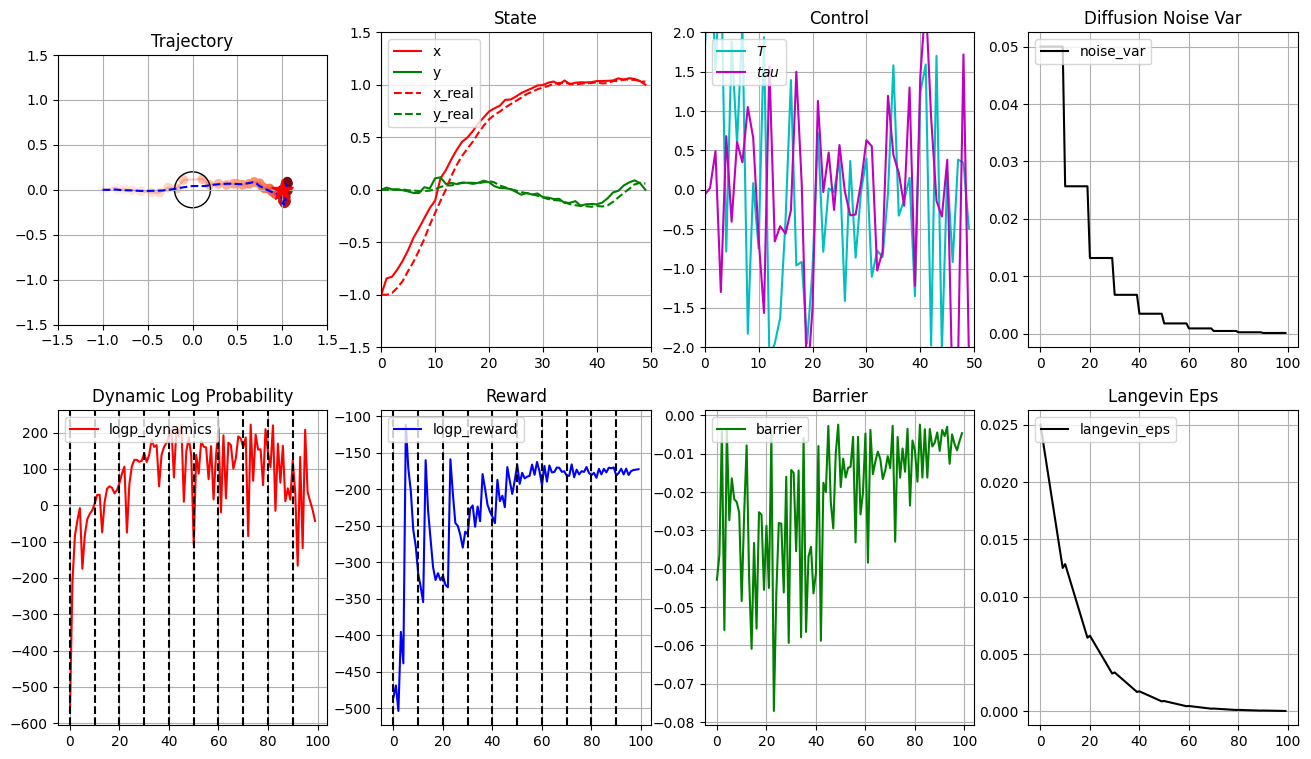

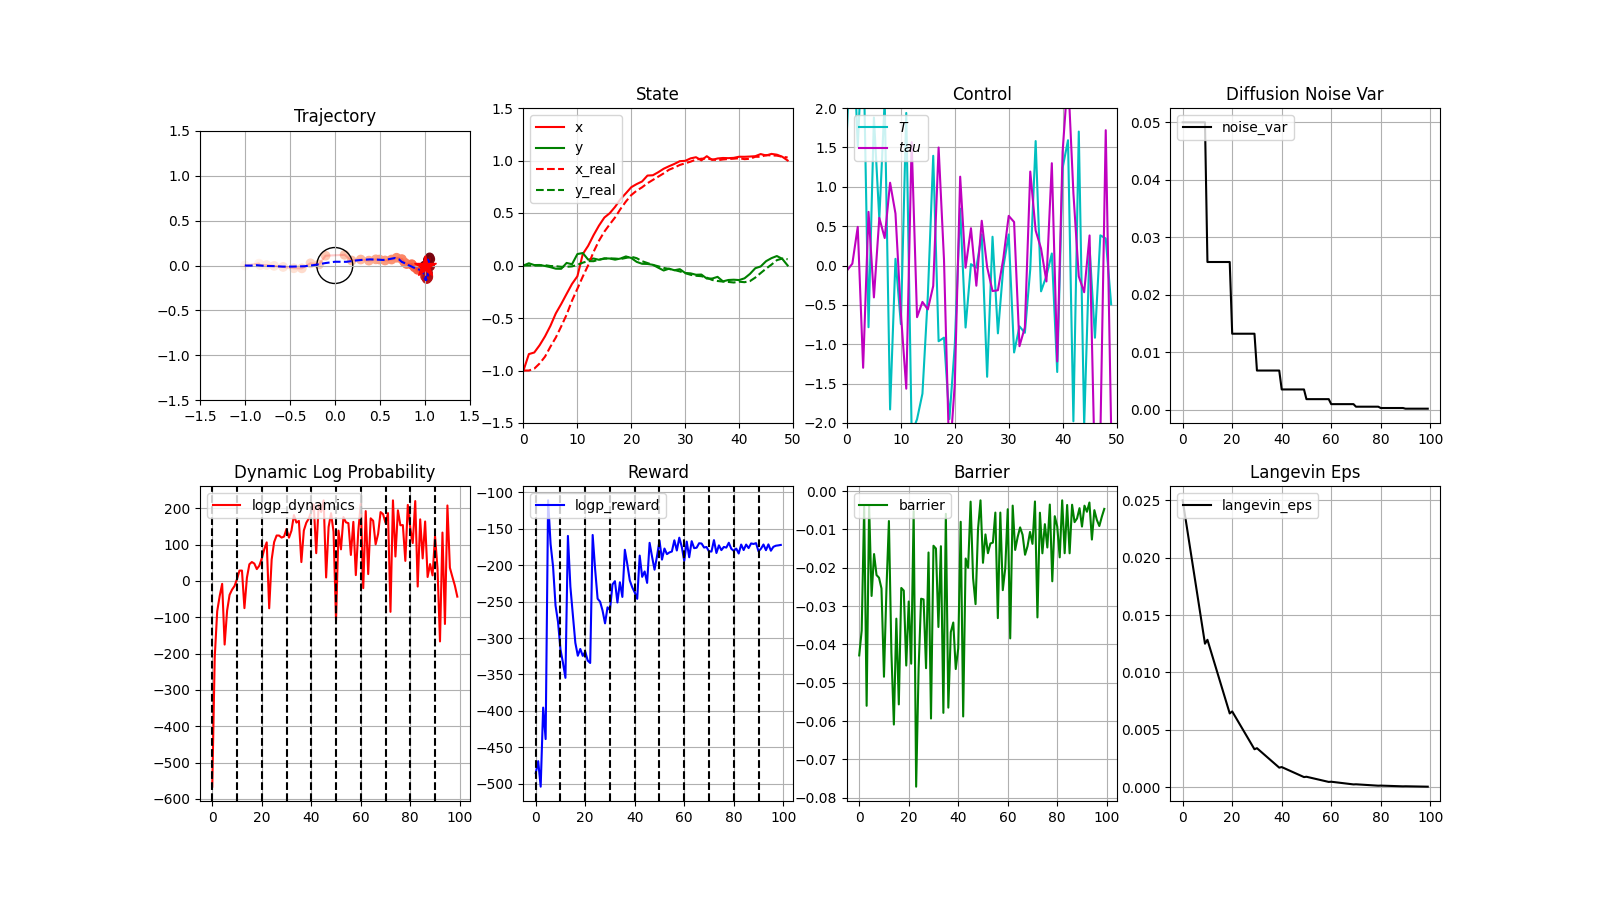

In [63]:
save_infos = []
update_traj_jit = jax.jit(update_traj)
get_logpd_scan_jit = jax.jit(get_logpd_scan)
for d_step in range(diffuse_step):
    noise_var = noise_var_schedule[d_step]
    params = params.replace(noise_var=noise_var)
    for sub_step in range(diffuse_substeps):
        langevin_eps = (
            langevin_eps_schedule[sub_step] * (params.noise_var / 2e-5)
        )
        params = params.replace(langevin_eps=langevin_eps)

        rng, rng_traj = jax.random.split(rng)
        x_traj, u_traj = update_traj_jit(x_traj, u_traj, params, rng_traj)
        logpd = get_logpd_scan_jit(x_traj, u_traj, params)
        logp_reward = get_reward(x_traj, u_traj, params)

        # log info
        log_info["d_step"] = d_step
        log_info["sub_step"] = sub_step
        log_info["total_step"] = d_step * diffuse_substeps + sub_step
        log_info["logpd"] = (
            log_info["logpd"].at[d_step * diffuse_substeps + sub_step].set(logpd)
        )
        log_info["logp_reward"] = (
            log_info["logp_reward"]
            .at[d_step * diffuse_substeps + sub_step]
            .set(logp_reward)
        )
        log_info["barrier"] = (
            log_info["barrier"]
            .at[d_step * diffuse_substeps + sub_step]
            .set(get_barrier(x_traj, params))
        )
        log_info["noise_var"] = (
            log_info["noise_var"]
            .at[d_step * diffuse_substeps + sub_step]
            .set(noise_var)
        )
        log_info["langevin_eps"] = (
            log_info["langevin_eps"]
            .at[d_step * diffuse_substeps + sub_step]
            .set(langevin_eps)
        )
        jax.debug.print(
            "d_step = {d_step}, substep = {substep}, logp_dynamic = {x:.2f}, logp_reward = {y:.2f}",
            d_step=d_step,
            substep=sub_step,
            x=logpd,
            y=logp_reward,
        )

        # rollout dynamics to get real trajectory
        x_traj_real = jnp.zeros((horizon, n_state))
        x_traj_real = x_traj_real.at[0].set(params.init_state)
        for t in range(1, horizon):
            x_traj_real = x_traj_real.at[t].set(
                get_A(x_traj_real[t - 1], params) @ x_traj_real[t - 1]
                + get_B(x_traj_real[t - 1], params) @ u_traj[t - 1]
            )
        save_infos.append([x_traj, x_traj_real])

        clear_output()
# visualize trajectory
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
plot_traj(fig, axes,x_traj,u_traj,x_traj_real,log_info,"")
plt.show()

/home/pcy/mambaforge/envs/jax/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

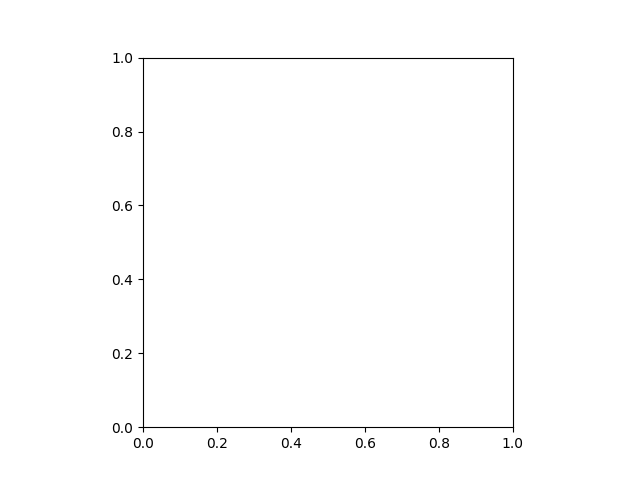

In [64]:
fig, ax = plt.subplots(1, 1)
# for info in save_infos:
for (i, (x_traj, x_traj_real)) in enumerate(save_infos):
    ax.scatter(
        x_traj[:, 0],
        x_traj[:, 1],
        c=range(horizon),
        cmap="Reds",
        marker="o",
        alpha=1.0,
    )
    ax.plot(
        x_traj[:, 0],
        x_traj[:, 1],
        "r",
        alpha=0.2,
    )
    ax.plot(
        x_traj_real[:, 0],
        x_traj_real[:, 1],
        "b--",
    )
    ax.grid()
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_aspect("equal", adjustable="box")
    # plot star at [1, 0]
    ax.plot(1.0, 0.0, "r*", markersize=16)
    # set title
    ax.set_title("Trajectory")
    # plot circle at [0, 0]
    circle = plt.Circle((0, 0), 0.2, color="black", fill=False)
    ax.add_artist(circle)
    # save figure to file
    plt.savefig(f"figure/{i}.png")
    
    ax.clear()

# render video
!rm figure/render.mp4
!ffmpeg -framerate 30 -i figure/%d.png -c:v libx264 -pix_fmt yuv420p figure/render.mp4
!rm figure/*.png